In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as tx

In [12]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [13]:
import wandb
wandb.login()

True

In [19]:
image_size = 128
batch_size = 64
def train_augmentation(image, mask, image_size):

    p = 0
    
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)
    
    if(random.random() < p):
        jitter = T.ColorJitter(brightness=1, hue=.3)
        image = jitter(image)
    if(random.random() < p):
        angle = random.uniform(30, 70)
        translate = (random.uniform(-0.1, 0.1) * image.size[0], random.uniform(-0.3, 0.3) * image.size[1])
        scale = random.uniform(0.5, 0.75)
        shear = [0.0, 0.0]  # Optional
    
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)
    
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor

    
train_dataset = Thyroid_Dataset("train_v2.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = Thyroid_Dataset("test_v2.csv", transform = test_augmentation, image_size = image_size, return_from_dataset = True, crop_DDTI = True, histo_match = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

image, mask, seg_type = next(iter(train_dataloader))
image = image
mask = mask

In [20]:
torch.std(image)

tensor(1.0000)

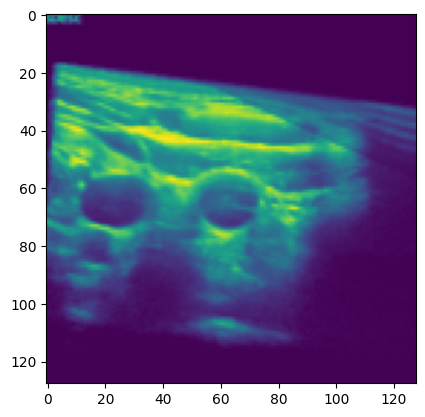

In [21]:
plt.imshow(image[10][0])

In [22]:
# model = Eff_Unet(
#         layers=[5, 5, 15, 10],
#         embed_dims=[40, 80, 192, 384],
#         downsamples=[True, True, True, True],
#         vit_num=6,
#         drop_path_rate=0.1,
#         num_classes=1,
#         resolution = image_size).cuda()
# model = HarDMSEG(in_channels = 1)
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")

In [23]:
# loss_fn_nodule = StructureLoss()
# loss_fn_gland = StructureLoss()

In [24]:
# optimizer = optim.Adam(model.parameters(), lr=0.01)

In [25]:
# seg_type

In [26]:
# for epoch in range(1000):
#     outputs = model(image)

#     nodule_output = outputs[:, 0:1, :, :][seg_type==1]
#     nodule_mask = mask[seg_type==1]
    
#     gland_output = outputs[:, 1:2, :, :][seg_type==2]
#     gland_mask = mask[seg_type==2]
#     # outputs = torch.sigmoid(logits)
#     # print(nodule_output.shape, nodule_mask.shape)
#     nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
#     gland_loss = loss_fn_gland(gland_output, gland_mask)
    
#     loss = nodule_loss + gland_loss
    
#     IOU = (IOU_score(nodule_output, nodule_mask) + IOU_score(gland_output, gland_mask)) / 2
    
#     dice_loss = DiceLoss()
#     # print(dice_loss(nodule_output, nodule_mask))
#     # print(dice_loss(gland_output, gland_mask)) 
#     DICE = ((1 - dice_loss(nodule_output, nodule_mask)) + (1 - dice_loss(gland_output, gland_mask))) / 2
    
#     # Backward and optimize
#     optimizer.zero_grad()   # clear previous gradients
#     loss.backward()         # compute gradients
#     optimizer.step()        # update weights

#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

In [27]:
# index = 4
# plt.subplot(1,2,1)
# plt.imshow(nodule_mask[index][0])
# nodule_output = (nodule_output > 0.5)
# plt.subplot(1,2,2)
# plt.imshow(nodule_output[index][0].detach().numpy())

In [28]:
# index = 4
# plt.subplot(1,2,1)
# plt.imshow(gland_mask[index][0])
# gland_output = (gland_output > 0.5)
# plt.subplot(1,2,2)
# plt.imshow(gland_output[index][0].detach().numpy())

In [29]:
def train(dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, seg_type in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)

        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]
        
        gland_output = outputs[:, 1:2, :, :][seg_type==2]
        gland_mask = mask[seg_type==2]

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        gland_loss = loss_fn_gland(gland_output, gland_mask)


        
        loss = nodule_loss + gland_loss
        IOU = (IOU_score(nodule_output, nodule_mask) + IOU_score(gland_output, gland_mask)) / 2

        dice_loss = DiceLoss()
        DICE = ((1 - dice_loss(nodule_output, nodule_mask)) + (1 - dice_loss(gland_output, gland_mask))) / 2

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    DDTI_total_loss = 0
    TN3K_total_loss = 0
    
    total_IOU = 0
    DDTI_total_IOU = 0
    TN3K_total_IOU = 0
    
    total_DICE = 0
    DDTI_total_DICE = 0
    TN3K_total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, seg_type, from_dataset in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]


        DDTI_nodule_output = nodule_output[from_dataset==1]
        TN3K_nodule_output = nodule_output[from_dataset==3]

        DDTI_nodule_mask = nodule_mask[from_dataset==1]
        TN3K_nodule_mask = nodule_mask[from_dataset==3]
        

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        DDTI_nodule_loss = loss_fn_nodule(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_nodule_loss = loss_fn_nodule(TN3K_nodule_output, TN3K_nodule_mask)
        
        IOU = IOU_score(nodule_output, nodule_mask)
        DDTI_IOU = IOU_score(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_IOU = IOU_score(TN3K_nodule_output, TN3K_nodule_mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(nodule_output, nodule_mask)
        DDTI_DICE = 1 - dice_loss(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_DICE = 1 - dice_loss(TN3K_nodule_output, TN3K_nodule_mask)
    

        total_loss += nodule_loss.item()
        DDTI_total_loss += DDTI_nodule_loss.item()
        TN3K_total_loss += TN3K_nodule_loss.item()
        
        total_IOU += IOU.item()
        DDTI_total_IOU += DDTI_IOU.item()
        TN3K_total_IOU += TN3K_IOU.item()
        
        total_DICE += DICE.item()
        DDTI_total_DICE += DDTI_DICE.item()
        TN3K_total_DICE += TN3K_DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader), DDTI_total_loss/len(dataloader), DDTI_total_IOU/len(dataloader), DDTI_total_DICE/len(dataloader), TN3K_total_loss/len(dataloader), TN3K_total_IOU/len(dataloader), TN3K_total_DICE/len(dataloader), 

In [30]:
epochs = 50
lr = 0.01
project = "thyroid"
name=name="PMFSNet_crop_DDTI_standardization"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [31]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 50, batch size : 64


In [32]:
# model = Eff_Unet(
#         layers=[5, 5, 15, 10],
#         embed_dims=[10, 20, 48, 96],
#         # embed_dims=[40, 80, 192, 384],
#         downsamples=[True, True, True, True],
#         vit_num=6,
#         drop_path_rate=0.1,
#         num_classes=1,
#         resolution = image_size).cuda()
# model = HarDMSEG(in_channels = 1, out_channels = 2)
# model = LightMed(in_channels = 1, out_channels = 2, image_size = image_size)
model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")

### If using pretrained model

In [33]:
# pretrained_name = "PMFSNet_baseline"
# # model = HarDMSEG(in_channels = 1)
# model = PMFSNet(in_channels = 1, out_channels = 1, dim = "2d")
# # model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# checkpoint = torch.load(f"models/{pretrained_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])

In [34]:
# loss_fn = DiceLoss()
loss_fn_nodule = StructureLoss()
loss_fn_gland = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, DDTI_total_loss_val, DDTI_total_IOU_val, DDTI_total_DICE_val, TN3K_total_loss_val, TN3K_total_IOU_val, TN3K_total_DICE_val = val(test_dataloader, model, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,

        "DDTI_val_loss": DDTI_total_loss_val,
        "DDTI_val_IOU": DDTI_total_IOU_val,
        "DDTI_val_DICE": DDTI_total_DICE_val,

        "TN3K_val_loss": TN3K_total_loss_val,
        "TN3K_val_IOU": TN3K_total_IOU_val,
        "TN3K_val_DICE": TN3K_total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))

00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:21<00:00,  4.63it/s]

train loss : 1.4123004757531799, train IOU : 0.4968035524574175, train DICE : 0.6434135891423367



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.32it/s]

val loss : 0.8788341760635376, val IOU : 0.4406300351023674, val DICE : 0.6176905751228332
epoch : 1



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:16<00:00,  6.22it/s]

train loss : 1.0419172196104975, train IOU : 0.6284043771205562, train DICE : 0.7682655317948597



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.09it/s]

val loss : 0.8071152627468109, val IOU : 0.4912619352340698, val DICE : 0.6637465506792068
epoch : 2



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:16<00:00,  6.27it/s]

train loss : 0.9414689446439838, train IOU : 0.6640509237157236, train DICE : 0.7956160242014593



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.59it/s]

val loss : 0.7843486994504929, val IOU : 0.5002724274992942, val DICE : 0.6639690279960633
epoch : 3



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.42it/s]

train loss : 0.8307933789668697, train IOU : 0.7055445549511673, train DICE : 0.8250475897647367



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.57it/s]

val loss : 0.7231297373771668, val IOU : 0.5502025425434113, val DICE : 0.7225175499916077
epoch : 4



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.43it/s]

train loss : 0.7625012421371913, train IOU : 0.7283121459554918, train DICE : 0.8431181801427708



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.68it/s]

val loss : 0.6786862581968307, val IOU : 0.5718713760375976, val DICE : 0.7242735534906387
epoch : 5



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.47it/s]

train loss : 0.7200945249878534, train IOU : 0.7429125745697777, train DICE : 0.8542172342243761



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.88it/s]

val loss : 0.7472957879304886, val IOU : 0.556272315979004, val DICE : 0.7112501293420792
epoch : 6



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.52it/s]

train loss : 0.6828366866206178, train IOU : 0.7563558999854739, train DICE : 0.8626465407928617



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.87it/s]

val loss : 0.6473603159189224, val IOU : 0.5926941424608231, val DICE : 0.7478079915046691
epoch : 7



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.43it/s]

train loss : 0.6419009418770818, train IOU : 0.7694186048932595, train DICE : 0.8729384429383986



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.58it/s]

val loss : 0.634919285774231, val IOU : 0.6030926764011383, val DICE : 0.7558676689863205
epoch : 8



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.40it/s]

train loss : 0.6166010558015049, train IOU : 0.7799232265736797, train DICE : 0.8774482129824044



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.42it/s]

val loss : 0.6385532230138778, val IOU : 0.6151086121797562, val DICE : 0.7514033049345017
epoch : 9



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.39it/s]

train loss : 0.5816540954136612, train IOU : 0.7917214738260402, train DICE : 0.8877492558838117



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.57it/s]

val loss : 0.6518135666847229, val IOU : 0.607040959596634, val DICE : 0.7576127350330353
epoch : 10



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.42it/s]

train loss : 0.5653464136147263, train IOU : 0.797545601825903, train DICE : 0.8904879423651365



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.54it/s]

val loss : 0.6383499920368194, val IOU : 0.6112435430288314, val DICE : 0.7609141498804093
epoch : 11



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.42it/s]

train loss : 0.5418649286326795, train IOU : 0.8056075797222628, train DICE : 0.8966206135136066



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.61it/s]

val loss : 0.5740285366773605, val IOU : 0.6478658109903336, val DICE : 0.7854010701179505
epoch : 12



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.45it/s]

train loss : 0.5159080816377507, train IOU : 0.8156853436243416, train DICE : 0.9024192354466656



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.73it/s]

val loss : 0.6142621353268624, val IOU : 0.6354887783527374, val DICE : 0.779038953781128
epoch : 13



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.49it/s]

train loss : 0.488846752313104, train IOU : 0.8244147867259413, train DICE : 0.908478303711013



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.88it/s]

val loss : 0.625209179520607, val IOU : 0.6378568768501282, val DICE : 0.7851712673902511
epoch : 14



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.54it/s]

train loss : 0.4632901944736443, train IOU : 0.8342817437530744, train DICE : 0.9146930964866488



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.85it/s]

val loss : 0.5851007997989655, val IOU : 0.6452254235744477, val DICE : 0.7894256770610809
epoch : 15



00%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:15<00:00,  6.48it/s]

train loss : 0.4601324722908511, train IOU : 0.8353923742133792, train DICE : 0.9158082515886514



00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.80it/s]

val loss : 0.593095950782299, val IOU : 0.6607697904109955, val DICE : 0.7977697223424911
epoch : 16


 92%|██████████████████████████████████████████████████████████████████████████▌      | 93/101 [00:14<00:01,  6.67it/s]

In [48]:
print(max_IOU)

0.6537312358617783


In [49]:
inference_name = "PMFSNet_baseline"
# model = HarDMSEG(in_channels = 1)
model = PMFSNet(in_channels = 1, out_channels = 1, dim = "2d")
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
checkpoint = torch.load(f"models/{inference_name}/last_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

RuntimeError: Error(s) in loading state_dict for PMFSNet:
	size mismatch for out_conv.conv.3.weight: copying a param with shape torch.Size([2, 60, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 60, 3, 3]).
	size mismatch for out_conv.conv.3.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).

In [ ]:

total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")


In [ ]:
DICE = 0
# model.to("cuda")
model.eval()
for image, mask in tqdm(test_dataloader):
    image, mask = image, mask
    preds = model(image)
    DICE += (1 - dice_loss(preds, mask)).item()
print(DICE/len(test_dataloader))

In [ ]:
index = 7
plt.subplot(1,2,1)
plt.imshow(preds[index][0])
plt.subplot(1,2,2)
plt.imshow(mask[index][0])

In [ ]:
dice_loss = DiceLoss()
print(1 - dice_loss(preds, mask))

In [ ]:
plt.imshow(mask[index][0])